# EDP : Analyse mathématique et principes de la méthode des éléments finis 

### Jed Moutahir et Steven Zheng, groupe B2

# 1 Equation aux dérivées partielles élliptiques 

## 1.1 Position du problème et mise en forme variationnelle

Soit $\Omega = ]0,1[ \times ]0,1[ \subset \R^2$ et $\partial \Omega$ sa frontière partitionnée en deux sous-ensembles $\partial \Omega_{n} \cup \partial \Omega_{d}  = \partial \Omega$. Etant donnée $f \in L^2(\Omega) $, $u_{d} \in H^1(\Omega)$ et $g \in L^2(\partial \Omega_n)$, le problème de Laplace revient à déterminer $u$ solution de:

$$
\left\{
    \begin{array}{ll}
        -\Delta u(x,y) = f(x,y) &  sur ~ \Omega, \\
        u(x,y) = u_d(x,y) & sur  ~ \partial \Omega_d, \\
        \frac{\partial u(x,y)}{\partial n} = g(x,y) & sur ~ \partial \Omega_n
    \end{array}
\right.
$$


- Formulation variationnelle du problème :

On cherche à interpréter le problème au sens des distributions. On cherche $u \in H^2(\Omega)$. 

Le problème se réécrit :

$$
\left\{
    \begin{array}{ll}
        -\Delta u(x,y) = f(x,y) & dans ~ L^2(\Omega) \\
        \gamma_0 (u(x,y)) = u_d(x,y) & dans ~ H^1(\partial\Omega_d) \\
        \gamma_1 (u(x,y)) = g(x,y) & dans ~ L^2(\partial\Omega_n) 
    \end{array}
\right.
$$



## 1.2  Partie théorique

### Etape 1


On cherche donc $u \in H^2(\Omega) \bigcap H^1(\Omega)$.

En intégrant sur $\Omega$ et en multipliant par un $w \in L^2(\Omega)$ on obtient $$\displaystyle \int_\Omega {-\Delta uw} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x$$

Or $H^1(\Omega) \subseteq L^2(\Omega)$, on en vient donc à prendre un $w \in H^1(\Omega)$ pour trouver $ u \in H^2(\Omega)$ tel que  $$- \displaystyle \int_\Omega {\Delta u w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x$$

Pour $v \in H^1(\Omega)$ et $u \in H^2(\Omega)$ on a la formule de Green $- \displaystyle \int_\Omega {\Delta u  v} \, \mathrm{d}x = \displaystyle \int_\Omega {\nabla u . \nabla v} \, \mathrm{d}x - \displaystyle \int_{\partial\Omega} {\gamma_1(u) \gamma_0 (v)} \, \mathrm{d}\gamma $.

Ce qui nous donne que l'on peut chercher $u \in H^2(\Omega)$ tel que avec un $w \in H^1(\Omega)$  $$\displaystyle \int_\Omega {\nabla u . \nabla w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}\gamma$$

On peut donc effectuer la recherche de $u$ sur le sous-espace $H^1(\Omega)$.

De plus on a l'union disjointe $\partial\Omega = \partial\Omega_n \bigcup \partial\Omega_d$ donc en séparant l'intégrale on obtient :

$$\displaystyle \int_\Omega {\nabla u . \nabla w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega_n} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}\gamma + \displaystyle \int_{\partial\Omega_d} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}\gamma$$

On a l'égalité suivante dans le domaine des distributions $\forall(x,y) \in \partial\Omega_n : \gamma_1(u(x,y)) = \frac{\partial u(x,y)}{\partial n} = g(x,y)$.

De plus, le problème impose $\forall(x,y) \in \partial\Omega_d$  $u(x,y) = u_d(x,y)$ donc $v = u - u_d \in H^1_0(\Omega)$.

En prenant $w$ dans l'espace $H^1_0(\Omega)$, $\gamma_0(w) = 0$ sur $\partial\Omega_d$, ce qui donne $\displaystyle \int_{\partial\Omega_d} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}\gamma = 0$. 

L'égalité précédente se réécrit donc avec ces modifications : 

$$\displaystyle \int_\Omega {\nabla (v + u_d) . \nabla w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega_n} {g \gamma_0 (w)} \, \mathrm{d}\gamma$$

Donc le problème s'écrit : on cherche $u \in H^1(\Omega)$ tel que $$\displaystyle \int_\Omega {\nabla v . \nabla w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega_n} {g \gamma_0 (w)} \, \mathrm{d}\gamma - \displaystyle \int_\Omega {\nabla u_d . \nabla w} \, \mathrm{d}x$$ avec $v,w \in H^1_0(\Omega)$, $v = u - u_d$.


### Etape 2

 - Ce probleme s'écrit donc $A(v,w) = L(w)$ avec 

$$
A : \left\{
    \begin{aligned}
        H^1_0(\Omega) \times H^1_0(\Omega) & \longrightarrow \mathbb{R}\\
        (v,w) & \longrightarrow \displaystyle \int_\Omega {\nabla v . \nabla w} \, \mathrm{d}x
    \end{aligned}
\right.
$$

$$
L : \left\{
    \begin{aligned}
        H^1_0(\Omega) & \longrightarrow \mathbb{R}\\
        w & \longrightarrow \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega_n} {g \gamma_0 (w)} \, \mathrm{d}\gamma
         - \displaystyle \int_\Omega {\nabla u_d . \nabla w} \, \mathrm{d}x
    \end{aligned}
\right.
$$

$(H^1_0(\Omega), <.,.>_{1,\Omega})$ est un Hilbert

$A$ est une *forme bilinéaire* par linéarité de la dérivée et de l'intégrale, *continue* car $\mid a(u,v)\mid = \mid <u,v>_{1,\Omega} \leq \mid u\mid_{1,\Omega}\mid v\mid_{1,\Omega}$ par Cauchy-Schwarz sur un espace de Hilbert, et *coercive* car $\mid a(u,u)\mid = \mid u\mid_{1,\Omega}^2$

$L$ est une *forme linéaire* par linéarité de la dérivée et de l'intégrale.

$L$ est *continue* car $\mid L(w) \mid = 
\mid <f,w>_{L^2(\Omega)} + <g,\gamma_0 (w)>_{L^2(\partial\Omega_n)} - <\nabla u_d , \nabla w>_{1,\Omega}\mid $
d'où $ \mid L(w)\mid \leq \mid <f,w>_{L^2(\Omega)}\mid + \mid<g,\gamma_0 (w)>_{L^2(\partial\Omega_n)}\mid + \mid<\nabla u_d , \nabla w>_{1,\Omega}\mid$

Par inégalité de Cauchy-Schwarz on obtient :
$ \mid L(w) \mid \leq \|f\|_{L^2(\Omega)}\|w\|_{L^2(\Omega)} + \|g\|_{L^2(\partial\Omega)}\|\gamma_0 (w)\|_{L^2(\partial\Omega)} + |u_d|_{1,\Omega}|w|_{1,\Omega} $

$\Omega$ étant un ouvert fermé, on peut utiliser l'inégalité de Pointcarré, on a pour un $C > 0$, $\|w\|_{L^2(\Omega)} \leq C |w|_{1,\Omega}$, et $\gamma_0$ étant continue, il existe un $M > 0$ tel que $\|\gamma_0 (w)\|_{L^2(\partial\Omega)} \leq M |w|_{1,\Omega}$.

On a alors :
$$ \mid L(w) \mid \leq (\|f\|_{L^2(\Omega)} C + \|g\|_{L^2(\partial\Omega)} M + |u_d|_{1,\Omega})|w|_{1,\Omega} $$
qui donne bien la continuité de $L$ sur $H_0^1(\Omega)$.


Avec ses hypothèses vérifiées au dessus, on peut appliquer le théroème de Lax-Milgram qui donne l'existence d'une unique solution $v \in H^1_0(\Omega)$ qui vérifie 

$$ \forall w \in H^1_0(\Omega) A(v,w) = L(w)$$

Par définition on a $v = u - u_d$ donc $u$ est uniquement définie par $v$ et $u_d$, donc une solution unique existant pour $v$, il en est de même pour $u$ pour le problème initial. 
 

### Etape 3

- Avec $n$ le nombre de degrés de liberté, ($\eta_k$) les fonctions de base des éléments finis, on peut alors noter toute fonction $h \in H^1_0(\Omega)$ commme $h = \sum_{i=1}^n h_i \eta_i$ avec des ($h_i$) uniquement défini par la base des ($\eta_k$). 

On note par rapport à la fromule précédente $v_h = \sum_{i=1}^n v_i \eta_i$ et $w_h = \sum_{i=1}^n w_i \eta_i$ les fonctions discrète dans la base donnée.

On a alors la forme variationnelle discrète du problème : on cherche $u_h$ tel que $\forall w_h$ tel que ci-dessus $A(v_h,w_h) = L(w_h)$ ce qui se réécrit $\sum_{i,j} v_i w_j A(\eta_i, \eta_j) = \sum_{i=1}^n w_i L(\eta_i)$, $A$ et $L$ étant des formes bilinéaire et linéaire.

On cherche alors $$\sum_{i=1}^n w_i ( L(\eta_i) - \sum_{j=1}^n v_j A(\eta_j,\eta_i) ) = 0$$ et cela pour tout $w_i$ avec $i \in [1:n]$, qui implique alors que pour tout $i \in [1:n]$, $L(\eta_i) - \sum_{j=1}^n v_j A(\eta_j,\eta_i) = 0$.

On retrouve le système linéaire équivalent : $\sum_{j=1}^n v_j A(\eta_j,\eta_i) = L(\eta_i)$ pour $i \in [1:n]$, qui vaut aussi $Ax = b$ avec $A \in \mathbb{R}^{n \times n}$, $x,b \in \mathbb{R}^n$ vérifiant 

$$ A_{ij} = A(\eta_j,\eta_i) = \displaystyle \int_\Omega {\nabla \eta_j . \nabla \eta_i} = \displaystyle \int_\Omega {\nabla \eta_i^T \nabla \eta_j} $$

on a $\nabla u_d = \sum_{k=1}^n U_k \nabla \eta_k$ par définition de $U_k$, d'où 

$$ b_i = L(\eta_i) = \displaystyle \int_\Omega {f \eta_i} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega_n} {g \gamma_0 (\eta_i)} \, \mathrm{d}\partial\Omega_n(x) - \displaystyle \int_\Omega {(\sum_{k=1}^n U_k \nabla \eta_k) . \nabla \eta_i} \, \mathrm{d}x \Rightarrow b_i = \displaystyle \int_\Omega {f \eta_i} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega_n} {g \eta_i} \, \mathrm{d}\partial\Omega_n(x) - \sum_{k=1}^n U_k \displaystyle \int_\Omega {\nabla \eta_i^T \nabla \eta_k} \, \mathrm{d}x $$

et 

$$ x = (v_j)_{j\in[|1,n|]}$$

ce qui nous donne le système d'équations cherché. 

Le problème de Lax-Milgram s'applique aussi dans l'espace engendré par les fonctions de base des éléments finis $Vect((\eta_k)_k)$. Donc la solution $u_h$ est unique, son écriture dans la base des ($\eta_k$) est aussi unique car c'est une base de l'espace, il existe donc une unique solution au système $Ax = b$ car le vecteur $x$ est défini de manière unique par rapport à l'unique solution $u_h$. 


## 1.3 Mise en œuvre pratique

In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [2]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [3]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

### Partie I : maillage triangulaire et conditions de Dirichlet

In [4]:
#Construction de la matrice de raideur relative à un élement triangulaire
def raideur_triangle(sommets):
    a1,a2,a3=sommets
    # Calcul de la matrice J
    J = np.array([[a2[0]-a1[0], a3[0]-a1[0]],[a2[1]-a1[1], a3[1]-a1[1]]])
    alpha = np.linalg.det(J)
    
    m = np.zeros((3,3))
    # Calcul des coefficients de M 
    for i in range(3):
        for j in range(3):
            # Calcul des dérivées des fonctions de base sur le triangle 
            dni = (1/alpha) * np.array([[sommets[(i+1)%3][1]-sommets[(i+2)%3][1]], [sommets[(i+2)%3][0]-sommets[(i+1)%3][0]]])
            dnj = (1/alpha) * np.array([[sommets[(j+1)%3][1]-sommets[(j+2)%3][1]], [sommets[(j+2)%3][0]-sommets[(j+1)%3][0]]])
            # Calcul du coefficient (i,j)
            m[i][j] = (alpha/2) * (np.transpose(dni).dot(dnj))
    
    return m, alpha

In [5]:
#Assemblage de la matrice dans le cas d'un maillage uniquement constitué de triangles
def assemblage_triangle(elements3, coordinates, dirichlet):
    l = len(coordinates)
    a = np.zeros((l,l))
    b = np.zeros((l,1))
    
    def f(x,y):
        return 1

    # Calcul de la matrice de raideur globale
    for i in range(len(elements3)):
        # Récupération des sommets de l'élément
        sommets = [coordinates[elements3[i][0]], coordinates[elements3[i][1]], coordinates[elements3[i][2]]]
        # Calcul de la matrice de raideur de l'élément
        m, alpha = raideur_triangle(sommets)
        # Assemblage de la matrice de raideur globale
        # Calcul du centre de gravité de l'élément
        cg = (1/3) * (sommets[0] + sommets[1] + sommets[2])
        for j in range(3):
            for k in range(3):
                a[elements3[i][j]][elements3[i][k]] += m[j][k]
            #Approximation pour la quadrature du second membre

            b[elements3[i][j]] += (alpha/6) * f(cg[0],cg[1])

    #Condition de Dirichlet
    def ud(x,y):
        return 1
    
    ld, cd = np.shape(dirichlet)
    v = np.zeros((l,1))

    for i in range(ld):
        idsommet = dirichlet[i,0]
        x,y = coordinates[idsommet]
        v[idsommet] = ud(x,y)
    
    # modification de b par rapport à la condition de Dirichlet 
    b = b - a.dot(v)
    uh = v
    
    # calcul des éléments a l'intérieur du domaine
    sommets = [i for i in range(l)]
    sommets_int = np.setdiff1d(sommets, dirichlet)
    al = a[sommets_int]
    amod = al[:,sommets_int]
    bmod = b[sommets_int]
    # on calcul u sur les points intérieurs, avec les matrices 
    # A et b modifiées qui n'ont que les éléments qui 
    # permettent de calculer la solution sur l'intérieur du domaine 
    umod =  (np.linalg.inv(amod)).dot(bmod)
    uh[sommets_int] = umod 
    
    return uh, amod, bmod
    

    

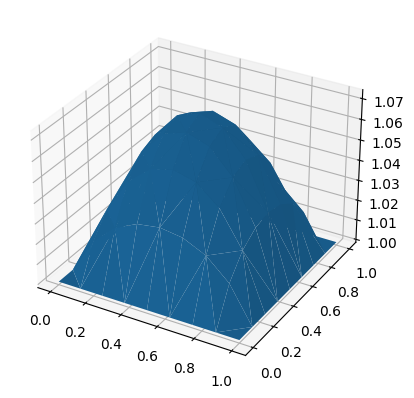

In [6]:
coordinates, elements3, dirichlet, neumann = maillage(9)
uh,a,b = assemblage_triangle(elements3, coordinates, dirichlet)
show(coordinates, (uh[:,0]))

### Partie II : maillage mixte et ajoût des conditions de Neumann

In [7]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

- Matrice de raideur associé à un élément de type quadrangle

On a $\nabla \phi (\xi, \zeta) = 
\left(
    \begin{array}{ll}
        \zeta - 1 & \xi - 1\\
        1 - \zeta & - \xi \\
        \zeta & \xi \\
        - \zeta & 1 - \xi \\
    \end{array}
\right)$

et d'après la formule du changement de variable, on trouve pour la matrice de raideur $M$ :
$M_{ij} =  \displaystyle \int_{[0,1]} \int_{[0,1]} {\nabla \phi_i^T (J_\phi^T J_\phi)^{-1} \nabla \phi_j ^T |J_\phi|}\, \mathrm{d}\xi \, \mathrm{d}\zeta$ avec $\nabla \phi_i$ la ligne $i$ du vecteur $\nabla \phi$.

En notant $(J_\phi^T J_\phi)^{-1} = 
\left(
    \begin{array}{ll}
        a & b\\
        b & c
    \end{array}
\right)$ la matrice Jacobienne de $\phi$ symétrique, on trouve par calcul des intégrales :

$ M = \frac{|J_\phi|}{6}
\left(
    \begin{array}{ll}
        2a + 3b + 2c & -2a + c & -a -3b - c & a - 2c\\
        -2a + c & 2a - 3b + 2c & a - 2c & - a + 3b - c \\
        -a -3b - c & a - 2c & 2a + 3b + 2c & -2a + c \\
        a - 2c & - a + 3b - c & -2a + c & 2a - 3b + 2c
    \end{array}
\right)$

Exemple de calcul de l'expression d'un coefficient de M ($M_{0,0}$) en passant par l'intégrale : 
$$\int_0^1{\int_0^1 {(y-1)(a(y-1) + b(x-1)) + (x-1)(b(y-1) + c(x-1)) dx}dy} = \frac{1}{6}(2a + 3b + 2c)$$

In [8]:
#calcul de la matrice de raideur élémentaire relative à un élément quadrangle 
#sommets : sommets d'un quadrangle dans le sens antihoraire
def raideur_quadrangle(sommets):
    a1,a2,a3,a4 = sommets
    # Calcul de la matrice J et des éléments utiles aux calculs 
    J = np.array([[a2[0]-a1[0], a4[0]-a1[0]], [a2[1]-a1[1], a4[1]-a1[1]]])
    Jnorm = np.linalg.norm(J)
    alpha = np.linalg.det(J)
    SJinv = np.linalg.inv(np.transpose(J).dot(J))
    a, b, c = SJinv[0,0], SJinv[0,1], SJinv[1,1]
    
    # calcul des coefficients de M 
    m = np.zeros((4,4))

    m[0,0] = 2*a + 3*b + 2*c
    m[0,1] = -2*a + c
    m[0,2] = -a -3*b - c
    m[0,3] = a - 2*c

    m[1,0] = -2*a + c
    m[1,1] = 2*a - 3*b + 2*c
    m[1,2] = a - 2*c
    m[1,3] = -a + 3*b - c

    m[2,0] = -a -3*b - c
    m[2,1] = a - 2*c
    m[2,2] = 2*a + 3*b + 2*c
    m[2,3] = -2*a + c

    m[3,0] = a - 2*c
    m[3,1] = -a + 3*b - c
    m[3,2] = -2*a + c
    m[3,3] = 2*a - 3*b + 2*c
    
    m = m*(Jnorm/6)
    
    return m, alpha 

In [9]:
#Assemblage de la matrice dans le cas d'un maillage uniquement constitué de rectangles
def assemblage_mixte(elements3, elements4, coordinates, dirichlet, neumann):
    l = len(coordinates)
    a = np.zeros((l,l))
    b = np.zeros((l,1))
    
    def f(x,y):
        return 1

    # Calcul de la matrice de raideur globale
    for i in range(len(elements3)):
        # Récupération des sommets de l'élément
        sommets = [coordinates[elements3[i][0]], coordinates[elements3[i][1]], coordinates[elements3[i][2]]]
        # Calcul de la matrice de raideur de l'élément
        m, alpha = raideur_triangle(sommets)
        # Assemblage de la matrice de raideur globale
        # Calcul du centre de gravité de l'élément
        cg = (1/3) * (sommets[0] + sommets[1] + sommets[2])
        for j in range(3):
            for k in range(3):
                a[elements3[i][j]][elements3[i][k]] += m[j][k]
            #Approximation pour la quadrature du second membre
            b[elements3[i][j]] += (alpha/6) * f(cg[0],cg[1])
    
    for i in range(len(elements4)):
        # Récupération des sommets de l'élément
        sommets = [coordinates[elements4[i][0]], coordinates[elements4[i][1]], coordinates[elements4[i][2]], coordinates[elements4[i][3]]]
        # Calcul de la matrice de raideur de l'élément
        m, alpha = raideur_quadrangle(sommets)
        # Assemblage de la matrice de raideur globale
        # Calcul du centre de gravité de l'élément
        cg = (1/4) * (sommets[0] + sommets[1] + sommets[2] + sommets[3])
        for j in range(4):
            for k in range(4):
                a[elements4[i][j]][elements4[i][k]] += m[j][k]
            #Approximation pour la quadrature du second membre
            b[elements4[i][j]] += (alpha/4) * f(cg[0],cg[1])

     # conditions de Dirichlet
    def ud(x,y):
        return 1
    
    v = np.zeros((l,1))
    for idsommet in dirichlet:
        x,y = coordinates[idsommet]
        v[idsommet] = ud(x,y)
    
    # modification de b par rapport à la condition de Dirichlet 
    b = b - a.dot(v)
    uh = v
    
    # conditions de Neumann 
    def g(x,y):
        return 1
    
    for i1,i2 in neumann:
        xa1,xa2, ya1,ya2 = coordinates[i1,0],coordinates[i2,0],coordinates[i1,1],coordinates[i2,1]
        # centre du segment
        x,y = (xa1 + xa2)/2, (ya1 + ya2)/2
        # distance entre les points
        d = math.sqrt((xa1 - xa2)**2 + (ya1 - ya2)**2)
        # approximation de la valeur ajoutée par les conditions de Neumann 
        # sur les sommets i1 et i2 
        ad = g(x,y)*(d/2)
        b[i1],b[i2] = b[i1] + ad, b[i2] + ad
    
    #calcul des éléments a l'intérieur du domaine
    sommets = [i for i in range(l)]
    sommets_int = np.setdiff1d(sommets, dirichlet)
    al = a[sommets_int]
    amod = al[:,sommets_int]
    bmod = b[sommets_int]
    # on calcul u sur les points intérieurs, avec les matrices 
    # A et b modifiées qui n'ont que les éléments qui 
    # permettent de calculer la solution sur l'intérieur du domaine 
    umod =  (np.linalg.inv(amod)).dot(bmod)
    uh[sommets_int] = umod
    
    return uh, amod, bmod


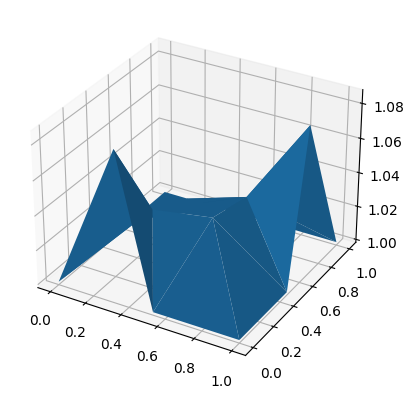

In [10]:
uh,ah,bh=assemblage_mixte(e3, e4, ccs, dds, nns)
show(ccs, (uh[:,0]))

##  1.4 Compléments : introduction d’un nouveau terme dans l’EDP

Dans cette partie, nous nous intéressons au problème suivant:

$$
\left\{
    \begin{array}{ll}
        -\Delta u(x,y) + c_0u(x,y ) & = & f(x,y) &  sur ~ \Omega, \\
        u(x,y) & = & 0 & sur  ~ \partial \Omega, \\

    \end{array}
\right.
$$

avec $c_0 > 0$ une constante.

- On cherche donc $u \in H^2(\Omega) \bigcap H^1(\Omega)$.

En intégrant sur $\Omega$ et en multipliant par un $w \in L^2(\Omega)$ on obtient $$\displaystyle \int_\Omega {-\Delta uw + c_0uw} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x$$

Or $H^1(\Omega) \subseteq L^2(\Omega)$, on en vient donc à prendre un $w \in H^1(\Omega)$ pour trouver $ u \in H^2(\Omega)$ tel que  $$- \displaystyle \int_\Omega {\Delta u w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x$$

Pour $v \in H^1(\Omega)$ et $u \in H^2(\Omega)$ on a la formule de Green $- \displaystyle \int_\Omega {\Delta u  v} \, \mathrm{d}x = \displaystyle \int_\Omega {\nabla u . \nabla v} \, \mathrm{d}x - \displaystyle \int_{\partial\Omega} {\gamma_1(u) \gamma_0 (v)} \, \mathrm{d}\gamma $.

Ce qui nous donne que l'on peut chercher $u \in H^2(\Omega)$ tel que avec un $w \in H^1(\Omega)$  $$\displaystyle \int_\Omega {\nabla u . \nabla w + c_0uw} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}\gamma$$

On peut donc effectuer la recherche de $u$ sur le sous-espace $H^1(\Omega)$.

De plus, le problème impose $\forall(x,y) \in \partial\Omega$  $u(x,y) = 0$ donc $v = u \in H^1_0(\Omega)$.

En prenant $w$ dans l'espace $H^1_0(\Omega)$, $\gamma_0(w) = 0$ sur $\partial\Omega$, ce qui donne $\displaystyle \int_{\partial\Omega} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}\gamma = 0$. 

L'égalité précédente se réécrit donc avec ces modifications : 

$$\displaystyle \int_\Omega {\nabla v . \nabla w + c_0vw} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x$$

Donc $$\displaystyle \int_\Omega {\nabla v . \nabla w} \, \mathrm{d}x + c_0\int_\Omega {vw} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x$$

Donc le problème s'écrit : on cherche $u \in H^1(\Omega)$ tel que $$\displaystyle \int_\Omega {\nabla v . \nabla w} \, \mathrm{d}x + c_0\int_\Omega {vw} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x$$ avec $v,w \in H^1_0(\Omega)$, $v = u$.


 - Ce probleme s'écrit donc $A(v,w) = L(w)$ avec 

$$
A : \left\{
    \begin{aligned}
        H^1_0(\Omega) \times H^1_0(\Omega) & \longrightarrow \mathbb{R}\\
        (v,w) & \longrightarrow \displaystyle \int_\Omega {\nabla v . \nabla w} \, \mathrm{d}x + c_0\int_\Omega {vw} \, \mathrm{d}x
    \end{aligned}
\right.
$$

$$
L : \left\{
    \begin{aligned}
        H^1_0(\Omega) & \longrightarrow \mathbb{R}\\
        w & \longrightarrow \displaystyle \int_\Omega {fw} \, \mathrm{d}x
    \end{aligned}
\right.
$$

$(H^1_0(\Omega), <.,.>_{H^1_0(\Omega)})$ est un Hilbert

$A$ est une *forme bilinéaire* par linéarité de la dérivée et de l'intégrale, *continue* car 
$$\mid a(u,v)\mid = \mid \displaystyle \int_\Omega {\nabla u . \nabla v} \, \mathrm{d}x + c_0\int_\Omega {uv} \, \mathrm{d}x \mid $$

$$\leq \mid \displaystyle \int_\Omega {\nabla u . \nabla v} \, \mathrm{d}x \mid + c_0 \mid \int_\Omega {uv} \, \mathrm{d}x \mid$$
$$\leq \displaystyle \int_\Omega {\mid \nabla u . \nabla v \mid} \, \mathrm{d}x + c_0 \int_\Omega {\mid uv \mid} \, \mathrm{d}x$$
$$\leq \lVert u \rVert _{H^1_0(\Omega)} \lVert v \rVert _{H^1_0(\Omega)} + c_0\lVert u \rVert _{L^2(\Omega)} \lVert v \rVert _{L^2(\Omega)}$$
$\Omega$ est un ouvert borné sur $\mathbb{R}^n$ donc on peut utiliser l'inégalité de Poincaré
$$\leq \lVert u \rVert _{H^1_0(\Omega)} \lVert v \rVert _{H^1_0(\Omega)} + c_0C^2 \lVert u \rVert _{H^1_0(\Omega)} \lVert v \rVert _{H^1_0(\Omega)}$$
$$\leq (1 + c_0C^2) \lVert u \rVert _{H^1_0(\Omega)} \lVert v \rVert _{H^1_0(\Omega)}$$

$A$ est *coercive* car
$$\mid a(u,u)\mid = \mid \displaystyle \int_\Omega {\nabla u ^2} \, \mathrm{d}x + c_0\int_\Omega {u^2} \, \mathrm{d}x \mid$$
$$=\displaystyle \int_\Omega {\nabla u ^2} \, \mathrm{d}x + c_0\int_\Omega {u^2} \, \mathrm{d}x$$
$$= \lVert u \rVert _{H^1_0(\Omega)}^2 + c_0\lVert u \rVert _{H^1(\Omega)}^2$$
$$\geq \lVert u \rVert _{H^1_0(\Omega)}^2 + c_0\lVert u \rVert _{H^1_0(\Omega)}^2$$
$$\geq (1 + c_0) \lVert u \rVert _{H^1_0(\Omega)}^2$$


$L$ est une *forme linéaire* par linéarité de la dérivée et de l'intégrale.

$L$ est *continue* :
On sait que $\mid L(w) \mid = \mid <f,w>_{L^2(\Omega)} \mid $

Par inégalité de Cauchy-Schwarz on obtient :
$ \mid L(w) \mid \leq \|f\|_{L^2(\Omega)}\|w\|_{L^2(\Omega)} $

$\Omega$ étant un ouvert fermé, on peut utiliser l'inégalité de Poincaré, on a pour un $C > 0$, $\|w\|_{L^2(\Omega)} \leq C \lVert w \rVert _{H^1_0(\Omega)}$.

On a alors :
$$ \mid L(w) \mid \leq \|f\|_{L^2(\Omega)} C \lVert w \rVert _{H^1_0(\Omega)} $$
qui donne bien la continuité de $L$ sur $H_0^1(\Omega)$.


Avec ses hypothèses vérifiées au dessus, on peut appliquer le théroème de Lax-Milgram qui donne l'existence d'une unique solution $v \in H^1_0(\Omega)$ qui vérifie 

$$ \forall w \in H^1_0(\Omega) A(v,w) = L(w)$$

Par définition on a $v = u$ donc $u$ est uniquement définie par $v$, donc une solution unique existant pour $v$, il en est de même pour $u$ pour le problème initial. 
 